# Example of usage Spark OCR for Tables Recognition

This notebook demonstrate end-to-end pipeline for extract tabular data from image-based documents.

For more details about table recognition please read: [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

## Install spark-ocr python packge

Need to specify:
- secret
- license
- aws credentials

In [1]:
secret = ""
license = ""
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"
imagePath = "./data/tab_images/*.jpg"

In [2]:
#%%bash
#if python -c 'import google.colab' &> /dev/null; then
#    echo "Run on Google Colab!"
#    echo "Install Open JDK"
#    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
#    java -version
#fi

In [3]:
# install from PYPI using secret
#%pip install spark-ocr==$version+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade
#%pip install --upgrade spark-ocr==4.0.0+spark32 --user --extra-index-url https://pypi.johnsnowlabs.com/$secret --upgrade

In [4]:
import os
import sys

if AWS_ACCESS_KEY_ID != "":
    os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
    os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY
    
if license:
    os.environ['JSL_OCR_LICENSE'] = license
    
#if 'google.colab' in sys.modules:
#  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

## Initialization of spark session
Need specify path to `spark-ocr-assembly.jar` or `secret`

In [5]:
from pyspark import SparkConf
from sparkocr import start

spark = start(secret=secret, jar_path=spark_ocr_jar_path)

spark

Spark version: 3.1.3
Spark NLP version: 4.0.0
Spark NLP for Healthcare version: 4.0.0
Spark OCR version: 4.0.1



## Read images and display it


    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/data/tab_images/cTDaR_t10168.jpg
    Resolution: 0 dpi
    Width: 1061 px
    Height: 1373 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


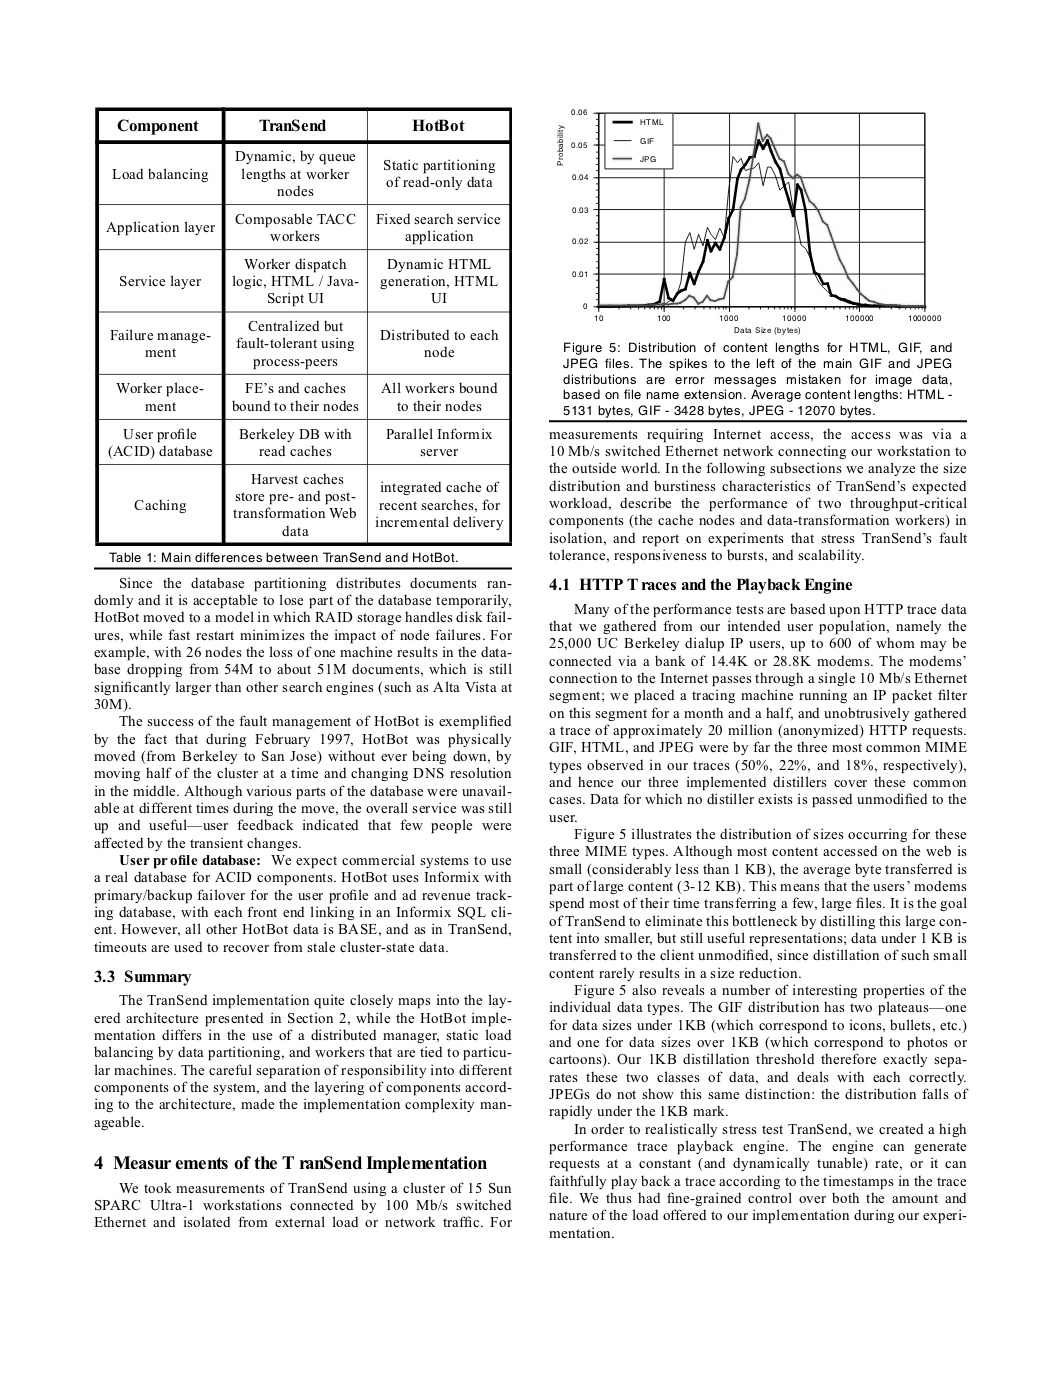


    Image #1:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/data/tab_images/cTDaR_t10011.jpg
    Resolution: 0 dpi
    Width: 816 px
    Height: 1056 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


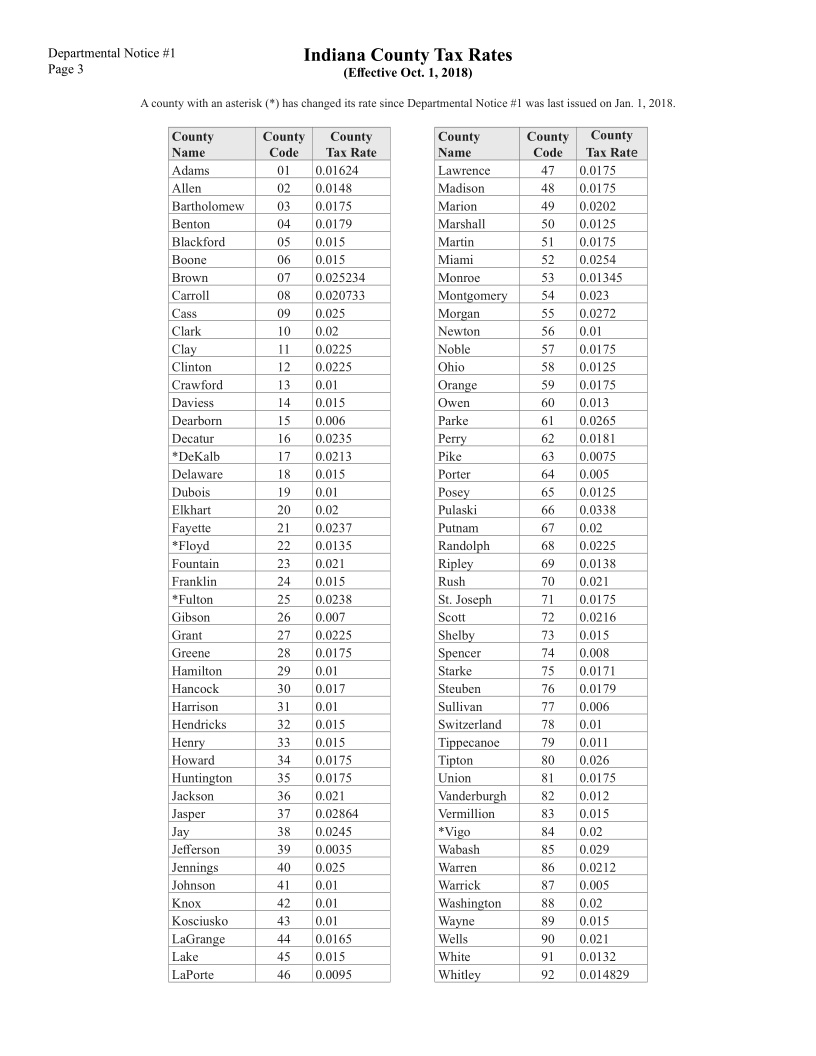

In [6]:
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images, display_tables, display_table
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f


image_df= spark.read.format("binaryFile").load(imagePath)

display_images(BinaryToImage().transform(image_df), "image")

## Define OCR Pipeline

In [7]:
binary_to_image = BinaryToImage()

table_detector = ImageTableDetector.pretrained("general_model_table_detection_v2", "en", "clinical/ocr")
table_detector.setInputCol("image")
table_detector.setOutputCol("region")

splitter = ImageSplitRegions()
splitter.setInputCol("image")
splitter.setInputRegionsCol("region")
splitter.setOutputCol("table_image")
splitter.setDropCols("image")
splitter.setImageType(ImageType.TYPE_BYTE_GRAY)

scaler = ImageScaler()
scaler.setInputCol("table_image")
scaler.setOutputCol("scaled_image")
scaler.setScaleFactor(2)

cell_detector = ImageTableCellDetector()
cell_detector.setInputCol("scaled_image")
cell_detector.setOutputCol("cells")
cell_detector.setKeepInput(True)

table_recognition = ImageCellsToTextTable()
table_recognition.setInputCol("scaled_image")
table_recognition.setCellsCol('cells')
table_recognition.setMargin(2)
table_recognition.setStrip(True)
table_recognition.setOutputCol('table')

pipeline = PipelineModel(stages=[
    binary_to_image,
    table_detector,
    splitter,
    scaler,
    cell_detector,
    table_recognition
])

general_model_table_detection_v2 download started this may take some time.
Approximate size to download 264.7 MB


## Run pipeline and show images with tables


    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/data/tab_images/cTDaR_t10168.jpg
    Resolution: 0 dpi
    Width: 419 px
    Height: 443 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


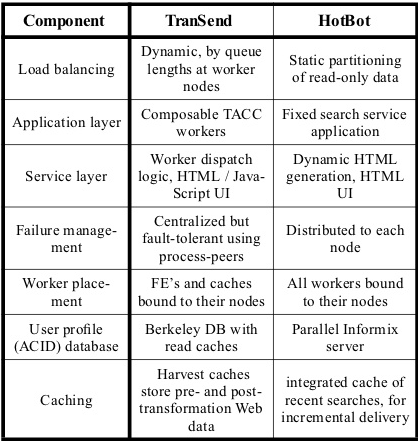


    Image #1:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/data/tab_images/cTDaR_t10011.jpg
    Resolution: 0 dpi
    Width: 222 px
    Height: 872 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


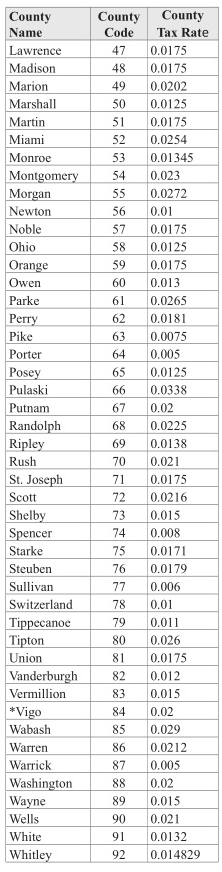


    Image #2:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/data/tab_images/cTDaR_t10011.jpg
    Resolution: 0 dpi
    Width: 229 px
    Height: 859 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


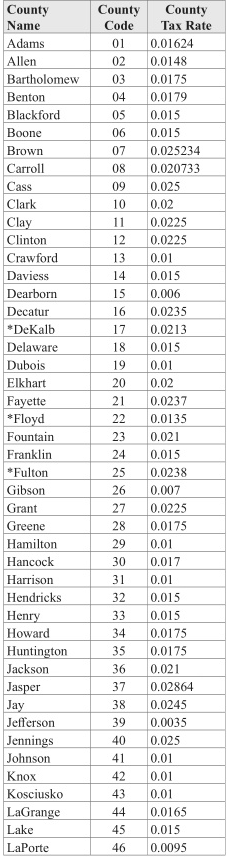

In [8]:
results = pipeline.transform(image_df).cache()
display_images(results, "table_image")

## Display recognized tables

In [9]:
display_tables(results)

Filename: cTDaR_t10011.jpg
Page:     0
Table:    0


col0        col1            col2
0    CountyName  CountyCode  CountyTax Rate
1      Lawrence          47          0.0175
2       Madison          48          O.O175
3        Marion          49          0.0202
4      Marshall          50          0.0125
5        Martin         S51          0.0175
6         Miami         52?          0.0254
7        Monroe         533         0.01345
8    Montvomerv          54           0.023
9        Morvan          55          0.0272
10       Newton          56            0.01
11        Noble          s7          O.O175
12         Ohio          58          0.0125
13       Orange          59          0.0175
14         Owen          60           0.013
15        Parke          6l          0.0265
16        Perry          62          O.OI81
17         Pike          63          0.0075
18       Porter          64           0.005
19        Posev          65          0.0125
20      Pulaski          66          0.0338
21       Putnam          67            0.02
22     Randolph          68          0.0225
23       Rinlev          69          0.0138
24         Rush          70           0.021
25   St. Joseph          71          0.0175
26        Scott          72          0.0216
27       Shelby          73           0.015
28      Spencer          74           0.008
29       Starke           7          0.0171
30      Steuben         716          0.0179
31     Sullivan          77           0.006
32  Switzerland          78            0.01
33   Tippecanoe          79           O.O11
34       Tipton          80           0.026
35        Union          RI          0.0175
36  Vanderburgh          R2           0.012
37   Vermillion           3           0.015
38        *Vigo          R4            0.02
39       Wabash          R5           0.029
40       Warren          R6          0.0212
41      Warrick          87           0.005
42   Washington          g8            0.02
43        Wavne           9           0.015
44        Wells          90           0.021
45        White          91          0.0132
46      Whitley          9?        0.014829

Filename: cTDaR_t10168.jpg
Page:     0
Table:    0


col0  \
0                                          Component   
1                                     Load balancing   
2                                  Application layer   
3                   Service layerFailure manage-ment   
4   Centralized butfault-tolerant usingprocess-peers   
5                    All workers boundto their nodes   
6                            Parallel Informixserver   
7  integrated cache ofrecent searches, forincreme...   

                                          col1  \
0                                    ‘TranSend   
1      Dynamic, by queuelengths at workernodes   
2                       Composable TACCworkers   
3  Worker dispatchlogic, HTML / Java-Script UI   
4                                         None   
5                  User profile(ACID) database   
6                                      Caching   
7                                         None   

                                                col2  
0                                             HotBot  
1               Static partitioningof read-only data  
2                    Fixed search serviceapplication  
3  Dynamic HTMLgeneration, HTMLUIDistributed to e...  
4                                               None  
5                        Berkeley DB withread caches  
6  Harvest cachesstore pre- and post-transformati...  
7                                               None

Filename: cTDaR_t10011.jpg
Page:     0
Table:    1


col0        col1            col2
0    CountyName  CountyCode  CountyTax Rate
1         Adams          ol         0.01624
2         Allen         Oo?          0.0148
3   Bartholomew          oO          O.O175
4        Benton          04          0.0179
5     Blackford          05           0.015
6         Boone          06           0.015
7         Brown          07        0.025234
8       Carroll          og        0.020733
9          Cass          09           0.025
10        Clark          10            0.02
11         Clav          ll          0.0225
12      Clinton          12          0.0225
13     Crawford          13            0.01
14      Daviess          14           0.015
15     Dearborn          15           0.006
16      Decatur          16          0.0235
17      *DeKalb          17          0.0213
18     Delaware          18           0.015
19       Dubois          19            0.01
20      Elkhart          20            0.02
21      Favette          21          0.0237
22       *Floyd          22          0.0135
23     Fountain          33           0.021
24     Franklin          24           0.015
25      *Fulton          25          0.0238
26       Gibson           6           0.007
27        Grant           7          0.0225
28       Greene          28          O.O175
29     Hamilton          29            0.01
30      Hancock          30           0.017
31     Harrison          31            0.01
32    Hendricks          32           0.015
33        Henrv          33           0.015
34       Howard          34          O.O175
35   Huntington          35          0.0175
36      Jackson          %6           0.021
37       Jasper          37         0.02864
38          Jav          38          0.0245
39    Jefferson          39          0.0035
40     Jennines          40           0.025
41      Johnson          41            0.01
42         Knox          4?            0.01
43    Kosciusko          43            0.01
44     LaGrange          44          0.0165
45         Lake          45           0.015
46      LaPorte          46          0.0095